# 0. 코랩환경 구성하기
- Data 연동하기

# A. Machine Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Data Loading
- Train data를 로딩합니다.
- Test data를 로딩합니다.
- shape을 확인합니다.

In [2]:
train = pd.read_pickle("./A34_ml_train.pkl")
test = pd.read_pickle("./A34_ml_test.pkl")
train.shape, test.shape

((600, 3073), (300, 3072))

In [3]:
train.head(5)
#3072개의 픽셀과 label

,0,1,2,3,4,5,6,7,8,9,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,label
0,0.160784,0.121569,0.129412,0.149020,0.109804,0.117647,0.062745,0.047059,0.039216,0.070588,...,0.054902,0.054902,0.054902,0.039216,0.039216,0.039216,0.003922,0.003922,0.003922,3
1,0.964706,0.964706,0.960784,0.866667,0.866667,0.850980,0.854902,0.854902,0.839216,0.854902,...,0.854902,0.858824,0.862745,0.843137,0.847059,0.850980,0.952941,0.952941,0.952941,3
2,0.564706,0.415686,0.180392,0.478431,0.349020,0.149020,0.450980,0.317647,0.129412,0.450980,...,0.788235,0.686275,0.509804,0.698039,0.611765,0.454902,0.729412,0.611765,0.411765,3
3,0.396078,0.286275,0.152941,0.411765,0.286275,0.145098,0.419608,0.286275,0.141176,0.423529,...,0.654902,0.501961,0.360784,0.717647,0.611765,0.470588,0.823529,0.752941,0.627451,3
4,0.309804,0.203922,0.160784,0.415686,0.278431,0.215686,0.588235,0.403922,0.294118,0.631373,...,0.356863,0.305882,0.290196,0.298039,0.239216,0.215686,0.223529,0.180392,0.168627,3


In [4]:
# X와 y로 나누기
# X는 한 픽셀을 Feature로 잡은 것 입니다.
# y는 label입니다. 
#label3 -> 만두
#label4 -> 새우튀김
#label5 -> 순대
X = train.drop(columns = ['label'])
y =train['label']
X_test= test.copy()
X.shape, y.shape

((600, 3072), (600,))

# 2. Data Visualization
- 0번째, 200번째, 400번째 데이터를 확인합니다.
- 전체 픽셀의 개수는 3072입니다. 이를 (32, 32, 3)으로 변환하면 3D Tensor 즉, image가 됩니다.

3


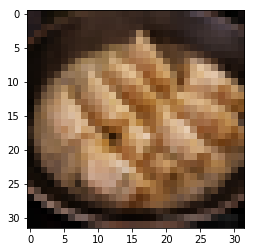

In [5]:
# 0번째 label 및 이미지 확인
#label3 -> 만두
print(y[0])
plt.imshow(X.iloc[0].values.reshape(32,32,3)) # (32,32,3)으로 변환

4


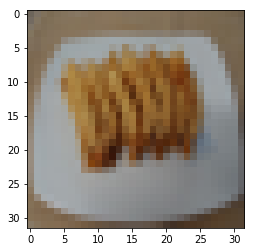

In [6]:
# 200번째 label 및 이미지 확인
#label4 -> 새우튀김
print(y[200])
plt.imshow(X.iloc[200].values.reshape(32,32,3))

5


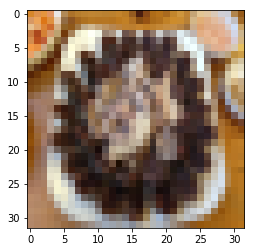

In [7]:
# 400번째 label 및 이미지 확인
#label5 -> 순대
print(y[400])
plt.imshow(X.iloc[400].values.reshape(32,32,3))

# 3. Validation set 구성
- 제공된 전체 학습데이터 600장 중 480장만 학습에 이용
- 나머지 120장은 Validation으로 구성하여 성능 검증에 이용

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_vld, y_train, y_vld = train_test_split(X, y, random_state=42, test_size = .2)
X_train.shape, X_vld.shape, y_train.shape, y_vld.shape

((480, 3072), (120, 3072), (480,), (120,))

# 4. Modeling
- Logistic Regression
- KNN
- 각각의 Hyperparaparameter를 튜닝시켜 가장 좋은 성능 모델로 Test를 진행하여 채점을 진행해보겠습니다.

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# 4.1 Hyper-parameter Searching
- Grid Search 방법을 진행합니다. (설정한 모든 경우의 조합으로 성능을 평가함.)
- 이를 5-Fold Cross Validation을 통해 가장 좋았던 파라미터를 찾습니다.

In [10]:
import sklearn
sklearn.__version__
## '0.22.1'

'0.22.1'

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [12]:
from sklearn._config import get_config, set_config

# default setting
get_config()["print_changed_only"]

False

In [13]:
# now changing it 
set_config(print_changed_only=False)

In [14]:
algorithmes = [LogisticRegression(), KNeighborsClassifier(n_jobs=-1)]

##실험 파라미터 셋팅###
params = []
params.append([{
    "solver" : ["saga"],
    "penalty" : ["l1"],
    "C" : [0.1,  5.0, 7.0, 10.0, 15.0, 20.0, 100.0]
    },{
    "solver" : ['liblinear'],
    "penalty" : ["l2"],
    "C" : [0.1,  5.0, 7.0, 10.0, 15.0, 20.0, 100.0]
    }
    ]) #Logistic Regression 하이퍼 파라미터

params.append({
    "p":[int(i) for i in range(1,3)],
    "n_neighbors":[i for i in range(2, 6)]}) #KNN 하이퍼 파라미터

In [15]:
#### 5 - Fold Cross Validation & Accuracy
scoring = ['accuracy']
estimator_results = []
for i, (estimator, params) in enumerate(zip(algorithmes,params)):
    gs_estimator = GridSearchCV(
            refit="accuracy", estimator=estimator,param_grid=params, scoring=scoring, cv=5, verbose=1, n_jobs=4)
    print(gs_estimator)

    gs_estimator.fit(X, y)
    estimator_results.append(gs_estimator)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=4,
             param_grid=[{'C': [0.1, 5.0, 7.0, 10.0, 15.0, 20.0, 100.0],
                          'penalty': ['l1'], 'solver': ['saga']},
                         {'C': [0.1, 5.0, 7.0, 10.0, 15.0, 20.0, 100.0],
                          'penalty': ['l2'], 'solver': ['liblinear']}],
             pre_dispatch='2*n_jobs', refit='accuracy',
             re

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:  2.8min finished
C:\Users\SeongMin\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=-1,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=4,
             param_grid={'n_neighbors': [2, 3, 4, 5], 'p': [1, 2]},
             pre_dispatch='2*n_jobs', refit='accuracy',
             return_train_score=False, scoring=['accuracy'], verbose=1)
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    8.5s finished


In [16]:
print("Logistic의 가장 좋은 성능은 ",estimator_results[0].best_score_)
print("KNN의 가장 좋은 성능은 ",estimator_results[1].best_score_)

Logistic의 가장 좋은 성능은  0.7433333333333334
KNN의 가장 좋은 성능은  0.5983333333333334


# 4.2 가장 좋은 모델의 가장 좋은 하이퍼 파라미터로 학습시키기
- 가장 좋은 모델로 전체 학습데이터 600장 중 480장만 학습에 이용
- 나머지 120장은 Validation으로 구성하여 성능 검증에 이용

In [17]:
#가장 좋은 모델 설정
model = estimator_results[0].best_estimator_
model.fit(X_train, y_train)

C:\Users\SeongMin\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

# 5. Validation 성능평가
- Validation set의 성능을 평가합니다.
- Recall, Precision 확인
- Confusion Matrix 확인

In [18]:
# validation 예측
pred = model.predict(X_vld)

In [19]:
# validation set 성능 확인
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_vld, pred))
print(confusion_matrix(y_vld, pred))

              precision    recall  f1-score   support

           3       0.74      0.53      0.62        43
           4       0.73      0.97      0.83        36
           5       0.71      0.71      0.71        41

    accuracy                           0.73       120
   macro avg       0.73      0.74      0.72       120
weighted avg       0.73      0.72      0.71       120

[[23  8 12]
 [ 1 35  0]
 [ 7  5 29]]


In [20]:
# 결과 확인
print("True", y_vld.values)
print("Prediction", pred)

True [3 5 5 3 3 4 3 5 3 4 3 3 3 5 4 4 3 4 3 3 3 5 5 5 4 5 3 3 5 5 5 3 3 4 3 5 3
 5 5 4 4 3 5 5 3 3 5 3 3 5 4 4 3 5 5 4 4 3 3 3 3 3 4 5 5 3 5 5 3 4 4 3 5 4
 5 5 4 4 5 5 4 5 5 4 3 3 3 4 4 4 4 5 3 4 4 4 4 3 5 3 3 4 5 4 3 5 3 4 4 5 3
 5 5 5 4 4 4 3 5 5]
Prediction [5 5 4 3 4 4 3 5 4 4 3 3 3 5 4 4 3 4 5 3 4 5 3 5 4 5 3 4 5 5 5 5 5 4 5 5 3
 5 4 4 4 3 5 5 5 3 5 5 3 3 4 4 3 5 3 4 4 3 5 3 5 3 3 3 5 4 5 5 5 4 4 3 4 4
 3 3 4 4 5 4 4 5 5 4 3 3 4 4 4 4 4 5 3 4 4 4 4 3 5 3 3 4 5 4 4 5 5 4 4 5 5
 5 5 5 4 4 4 4 4 3]


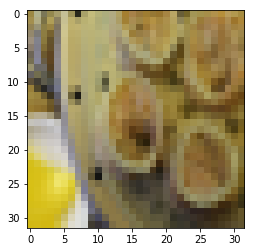

In [21]:
# 첫번째 데이터 True : 3(만두)
# 첫번째 데이터 Label : 5(순대)
# 즉 모델이 만두을 순대로 잘못예측한 개체이다.
plt.imshow(X_vld.iloc[0].values.reshape(32,32,3))

# 6. Testset 제출 및 Submission file 만들기
- 학습되지 않은 Validation 120장을 추가하여 600장을 한꺼번에 학습시킵니다.
- 이를 통해 Test data을 예측합니다.
- 제출 파일은 numpy array을 저장하여 .npy로 제출해주시기 바랍니다.

In [22]:
# 전체데이터로 학습하기
model.fit(X, y)

C:\Users\SeongMin\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
# 테스트 데이터 복사
X_test = test.copy()

In [24]:
final_pred = model.predict(X_test)

In [25]:
# final_pred를 npy로 저장합니다.
np.save("./submissin_file.npy", final_pred)

# B. Deep Learning

# 1. Data Loading
- Train data를 로딩합니다.
- shape을 확인합니다.

In [26]:
X_train = np.load("./A34_train_X.npy") #Train X data loading
y_train = np.load("./A34_train_y.npy") #Test X data loading
#label3 -> 만두
#label4 -> 새우튀김
#label5 -> 순대

In [27]:
y_train

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [28]:
# 각 class마다 200개씩 제공 -> 총 600장
# 이미지의 shpae은 RGB 채널을 갖고있는 32x32이미지 입니다. -> (32, 32, 3)
X_train.shape, y_train.shape

((600, 32, 32, 3), (600,))

# 2. Data Visualization
- 0번째, 200번째, 400번째 데이터를 확인합니다.

3


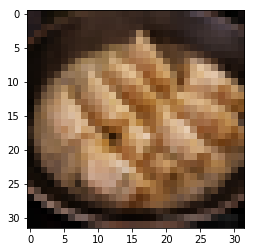

In [29]:
# 0번째 label 및 이미지 확인
# label3 -> 만두
print(y_train[0])
plt.imshow(X_train[0,:,:,:])

4


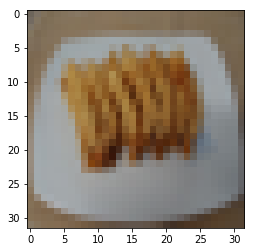

In [30]:
# 200번째 label 및 이미지 확인
#label4 -> 새우튀김
print(y_train[200])
plt.imshow(X_train[200,:,:,:])

5


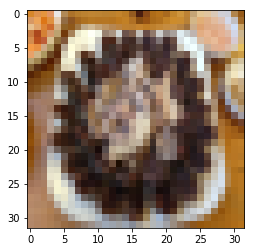

In [31]:
# 400번째 label 및 이미지 확인
#label5 -> 순대
print(y_train[400])
plt.imshow(X_train[400,:,:,:])

# 3. Validation set 구성
- 제공된 전체 학습데이터 600장 중 480장만 학습에 이용
- 나머지 120장은 Validation으로 구성하여 성능 검증에 이용

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_vld, y_train, y_vld = train_test_split(X_train, y_train, random_state=42, test_size = .2)
X_train.shape, X_vld.shape, y_train.shape, y_vld.shape

((480, 32, 32, 3), (120, 32, 32, 3), (480,), (120,))

# 4. Modeling
- Label 전처리 -> one-hot encoding
- Basic CNN 구성
- input layer -> Conv1 -> Maxpool1 -> Conv2 -> Maxpool2 -> Conv3 -> flatten -> Dense1 -> ouput layer
- activate function : Relu

In [33]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import np_utils

In [34]:
# 해당 부분은 label의 순서를 0부터 시작하게 하기 위해서 1을 빼줍니다.
# 본 데이터의 label은 3 4 5 으로 구성돼 있으므로 3을 빼면 -> 0 1 2로 바뀌게 됩니다.
y_train = y_train-3
y_vld = y_vld-3

In [35]:
y_train

array([0, 0, 1, 2, 0, 0, 2, 1, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 2, 0, 1, 2, 0, 0, 2, 2, 1, 1, 2, 1, 0, 2, 0, 0, 1, 1, 0, 2,
       1, 0, 1, 1, 2, 1, 1, 1, 2, 2, 0, 0, 2, 0, 0, 1, 0, 1, 2, 2, 2, 1,
       1, 2, 1, 1, 2, 2, 0, 1, 2, 1, 2, 1, 2, 0, 0, 2, 2, 0, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 0, 1, 0, 1, 0, 2, 0, 0, 2, 0, 1, 1, 2, 1, 1, 0, 1,
       0, 2, 1, 2, 2, 0, 2, 1, 2, 1, 2, 1, 2, 0, 0, 1, 2, 2, 0, 0, 0, 0,
       0, 2, 0, 0, 1, 1, 0, 1, 1, 1, 2, 0, 1, 2, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 2, 2, 0, 0, 2, 2, 0, 2, 2, 1, 2, 1, 1, 0, 2, 1, 0, 1, 0, 0, 1,
       2, 0, 2, 1, 0, 2, 2, 2, 0, 1, 0, 1, 0, 0, 0, 2, 1, 2, 1, 0, 1, 0,
       2, 2, 0, 1, 2, 2, 1, 1, 1, 1, 2, 0, 1, 0, 0, 1, 1, 2, 0, 0, 1, 1,
       1, 2, 1, 0, 1, 2, 2, 0, 2, 1, 0, 1, 0, 2, 2, 0, 2, 1, 1, 2, 0, 2,
       0, 0, 1, 2, 0, 1, 1, 1, 2, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 1, 0, 2,
       1, 1, 0, 1, 0, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 0, 0, 2, 2,
       2, 1, 1, 0, 2, 1, 1, 2, 0, 1, 0, 2, 0, 2, 1,

In [36]:
# 바꿔진 0 1 2 class를 one hot encoding을 실시합니다.
# ex) 0 -> [1, 0, 0] / 1-> [0, 1, 0] / 2 -> [0,0,1]
y_train = np_utils.to_categorical(y_train, 3)
y_vld= np_utils.to_categorical(y_vld, 3)

In [37]:
y_train

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [38]:
# CNN 아키텍처
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()          

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [39]:
# Early Stopping -> overfitting 방지
cb_early_stopping = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(X_train, y_train,
                    validation_data=(X_vld, y_vld),
                    epochs=100, batch_size=64, verbose=1,
                    callbacks=[cb_early_stopping])

print('\nAccuracy: {:.4f}'.format(model.evaluate(X_vld, y_vld)[1]))

Epoch 1/100
8/8 [==============================] - 1s 81ms/step - loss: 1.0790 - accuracy: 0.4125 - val_loss: 1.0243 - val_accuracy: 0.5500
Epoch 2/100
8/8 [==============================] - 0s 52ms/step - loss: 0.9712 - accuracy: 0.5750 - val_loss: 0.8347 - val_accuracy: 0.6833
Epoch 3/100
8/8 [==============================] - 0s 61ms/step - loss: 0.7982 - accuracy: 0.6667 - val_loss: 0.6100 - val_accuracy: 0.7417
Epoch 4/100
8/8 [==============================] - 1s 75ms/step - loss: 0.7080 - accuracy: 0.7229 - val_loss: 0.7609 - val_accuracy: 0.6833
Epoch 5/100
8/8 [==============================] - 0s 60ms/step - loss: 0.6317 - accuracy: 0.7312 - val_loss: 0.4825 - val_accuracy: 0.8000
Epoch 6/100
8/8 [==============================] - 0s 51ms/step - loss: 0.5490 - accuracy: 0.7854 - val_loss: 0.4554 - val_accuracy: 0.8083
Epoch 7/100
8/8 [==============================] - 0s 62ms/step - loss: 0.6405 - accuracy: 0.7146 - val_loss: 0.5840 - val_accuracy: 0.7250
Epoch 8/100
8/8 [===

# 5. Validation 성능평가
- Validation set의 성능을 평가합니다.
- Recall, Precision 확인
- Confusion Matrix 확인

In [40]:
# validation 예측
# pred에 3을 더하는 이유는 3번, 4번, 5번으로 바꿔주기 위해서
# pred = model.predict_classes(X_vld)  # TensorFlow 2.5.x
pred = np.argmax(model.predict(X_vld), axis=-1)
pred += 3

In [41]:
# y_vld.argmax(axis = 1)을 통해 one hot encoding을 원래 class로 바꿔준다.
# 여기에 3을 더해 3부터 시작하도록 바꿈.
y_vld = y_vld.argmax(axis = 1) + 3

In [42]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(classification_report(y_vld, pred))
print(confusion_matrix(y_vld, pred))
# Logistic 성능은 0.73이였으나 CNN은 0.81이다.

              precision    recall  f1-score   support

           3       0.79      0.72      0.76        43
           4       0.78      1.00      0.88        36
           5       0.89      0.76      0.82        41

    accuracy                           0.82       120
   macro avg       0.82      0.83      0.82       120
weighted avg       0.82      0.82      0.81       120

[[31  8  4]
 [ 0 36  0]
 [ 8  2 31]]


# 6. Testset 제출 및 Submission file 만들기
- 학습되지 않은 Validation 120장을 추가로 학습시킵니다. 이를 Fine Tuning이라 합니다.
- Fine Tuning은 간단히 말해서 학습된 모델에 다시 업데이트(학습) 시키는 과정입니다.
- 이를 통해 Test data을 예측합니다.
- 제출 파일은 numpy array을 저장하여 .npy로 제출해주시기 바랍니다.

In [43]:
# 다시 one hot encoding 해주기
y_vld -= 3
y_vld= np_utils.to_categorical(y_vld, 3)

In [44]:
model.fit(X_vld, y_vld, epochs=10, batch_size=64, verbose=1)

Epoch 1/10
2/2 [==============================] - 0s 50ms/step - loss: 0.4369 - accuracy: 0.8417
Epoch 2/10
2/2 [==============================] - 0s 50ms/step - loss: 0.3999 - accuracy: 0.8417
Epoch 3/10
2/2 [==============================] - 0s 47ms/step - loss: 0.4420 - accuracy: 0.8167
Epoch 4/10
2/2 [==============================] - 0s 46ms/step - loss: 0.4374 - accuracy: 0.8417
Epoch 5/10
2/2 [==============================] - 0s 56ms/step - loss: 0.3262 - accuracy: 0.8417
Epoch 6/10
2/2 [==============================] - 0s 55ms/step - loss: 0.3933 - accuracy: 0.8250
Epoch 7/10
2/2 [==============================] - 0s 58ms/step - loss: 0.3432 - accuracy: 0.8417
Epoch 8/10
2/2 [==============================] - 0s 49ms/step - loss: 0.3395 - accuracy: 0.8667
Epoch 9/10
2/2 [==============================] - 0s 49ms/step - loss: 0.3165 - accuracy: 0.8750
Epoch 10/10
2/2 [==============================] - 0s 64ms/step - loss: 0.2719 - accuracy: 0.8667


In [45]:
X_test = np.load("./A34_test_X.npy") #Train X data loading

In [46]:
# final_pred = model.predict_classes(X_test) # Tensorflow 2.5.x
final_pred = np.argmax(model.predict(X_test), axis=-1)
final_pred+=3

In [47]:
# final_pred를 npy로 저장합니다.
np.save("./submissin_file.npy", final_pred)